<a href="https://colab.research.google.com/github/LoniQin/deep_learning_notebooks/blob/master/mxnet/DCGAN_Pockermon_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Packages


In [2]:
!pip install d2l==0.16.2
!pip install -U mxnet-cu101==1.7.0


     |████████████████████████████████| 81kB 5.6MB/s 
     |███████████████████████████████▌| 834.1MB 1.4MB/s eta 0:00:09tcmalloc: large alloc 1147494400 bytes == 0x55705335c000 @  0x7f2f52cf7615 0x5570192cd06c 0x5570193aceba 0x5570192cfe8d 0x5570193c199d 0x557019343fe9 0x55701933eb0e 0x5570192d177a 0x557019343e50 0x55701933eb0e 0x5570192d177a 0x55701934086a 0x5570193c27c6 0x55701933fee2 0x5570193c27c6 0x55701933fee2 0x5570193c27c6 0x55701933fee2 0x5570193c27c6 0x55701933fee2 0x5570192d169a 0x55701933fc9e 0x55701933ee0d 0x5570192d177a 0x55701933fa45 0x5570192d169a 0x55701933fa45 0x55701933eb0e 0x5570192d177a 0x55701934086a 0x55701933eb0e
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


## Importing Packages

In [3]:
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## The Pokemon Dataset

Now we download [pokemondb](https://pokemondb.net/sprites) dataset, a collection of Pokemon sprites.


In [4]:
#@save
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = gluon.data.vision.datasets.ImageFolderDataset(data_dir)

We resize each image into $64\times 64$. The `ToTensor` transformation will project the pixel value into $[0, 1]$, while our generator will use the tanh function to obtain outputs in $[-1, 1]$. Therefore we normalize the data with $0.5$ mean and $0.5$ standard deviation to match the value range.


In [5]:
batch_size = 256
transformer = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(64),
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize(0.5, 0.5)])
data_iter = gluon.data.DataLoader(pokemon.transform_first(transformer),
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=d2l.get_dataloader_workers())

Let us visualize the first 20 images.


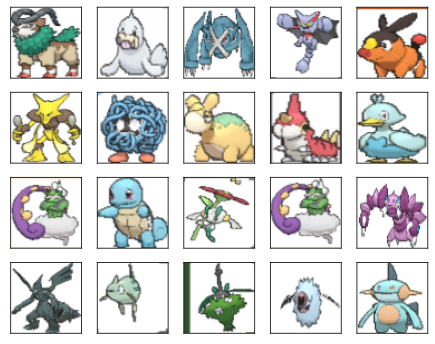

In [6]:
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20, :, :, :].transpose(0, 2, 3, 1) / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

## Building The Generator

The generator needs to map the noise variable $\mathbf z\in\mathbb R^d$, a length-$d$ vector, to a RGB image with width and height to be $64\times 64$ . In :numref:`sec_fcn` we introduced the fully convolutional network that uses transposed convolution layer (refer to :numref:`sec_transposed_conv`) to enlarge input size. The basic block of the generator contains a transposed convolution layer followed by the batch normalization and ReLU activation.


In [28]:
class GeneratorBlock(nn.Block):
    def __init__(self, channels, kernel_size=4, strides=2, padding=1,
                 **kwargs):
        super(GeneratorBlock, self).__init__(**kwargs)
        self.conv2d_trans = nn.Conv2DTranspose(channels, kernel_size, strides,
                                               padding, use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.Activation('relu')

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In default, the transposed convolution layer uses a $k_h = k_w = 4$ kernel, a $s_h = s_w = 2$ strides, and a $p_h = p_w = 1$ padding. With a input shape of $n_h^{'} \times n_w^{'} = 16 \times 16$, the generator block will double input's width and height.

$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= [(n_h k_h - (n_h-1)(k_h-s_h)- 2p_h] \times [(n_w k_w - (n_w-1)(k_w-s_w)- 2p_w]\\
  &= [(k_h + s_h (n_h-1)- 2p_h] \times [(k_w + s_w (n_w-1)- 2p_w]\\
  &= [(4 + 2 \times (16-1)- 2 \times 1] \times [(4 + 2 \times (16-1)- 2 \times 1]\\
  &= 32 \times 32 .\\
\end{aligned}
$$


In [29]:
x = np.zeros((2, 3, 16, 16))
generator = GeneratorBlock(20)
generator.initialize()
generator(x).shape

(2, 20, 32, 32)

If changing the transposed convolution layer to a $4\times 4$ kernel, $1\times 1$ strides and zero padding. With a input size of $1 \times 1$, the output will have its width and height increased by 3 respectively.


In [30]:
x = np.zeros((2, 3, 1, 1))
generator2 = GeneratorBlock(20, strides=1, padding=0)
generator2.initialize()
generator(x).shape

(2, 20, 2, 2)

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.


In [48]:
image_width = 64
generator = nn.Sequential()
generator.add(GeneratorBlock(image_width * 8, strides=1, padding=0),  # Output: (64 * 8, 4, 4)
          GeneratorBlock(image_width * 4),  # Output: (64 * 4, 8, 8)
          GeneratorBlock(image_width * 2),  # Output: (64 * 2, 16, 16)
          GeneratorBlock(image_width),  # Output: (64, 32, 32)
          nn.Conv2DTranspose(3, kernel_size=4, strides=2, padding=1,
                             use_bias=False,
                             activation='tanh'))  # Output: (3, 64, 64)

Generate a 100 dimensional latent variable to verify the generator's output shape.


In [49]:
x = np.zeros((1, 100, 1, 1))
generator.initialize()
generator(x).shape

(1, 3, 64, 64)

## Building the Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.


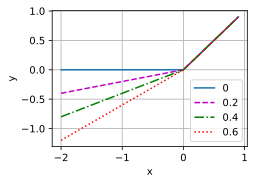

In [50]:
alphas = [0, .2, .4, .6, .8, 1]
x = np.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).asnumpy() for alpha in alphas]
d2l.plot(x.asnumpy(), Y, 'x', 'y', alphas)

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyperparameters of the convolution layer are similar to the transpose convolution layer in the generator block.


In [52]:
class Discriminatorblock(nn.Block):
    def __init__(self, channels, kernel_size=4, strides=2, padding=1,
                 alpha=0.2, **kwargs):
        super(Discriminatorblock, self).__init__(**kwargs)
        self.conv2d = nn.Conv2D(channels, kernel_size, strides, padding,
                                use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.LeakyReLU(alpha)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

A basic block with default settings will halve the width and height of the inputs, as we demonstrated in :numref:`sec_padding`. For example, given a input shape $n_h = n_w = 16$, with a kernel shape $k_h = k_w = 4$, a stride shape $s_h = s_w = 2$, and a padding shape $p_h = p_w = 1$, the output shape will be:

$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= \lfloor(n_h-k_h+2p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+2p_w+s_w)/s_w\rfloor\\
  &= \lfloor(16-4+2\times 1+2)/2\rfloor \times \lfloor(16-4+2\times 1+2)/2\rfloor\\
  &= 8 \times 8 .\\
\end{aligned}
$$


In [53]:
x = np.zeros((2, 3, 16, 16))
d_blk = Discriminatorblock(20)
d_blk.initialize()
d_blk(x).shape

(2, 20, 8, 8)

The discriminator is a mirror of the generator.


In [54]:
discriminator = nn.Sequential()
discriminator.add(Discriminatorblock(image_width),  # Output: (64, 32, 32)
          Discriminatorblock(image_width * 2),  # Output: (64 * 2, 16, 16)
          Discriminatorblock(image_width * 4),  # Output: (64 * 4, 8, 8)
          Discriminatorblock(image_width * 8),  # Output: (64 * 8, 4, 4)
          nn.Conv2D(1, kernel_size=4, use_bias=False))  # Output: (1, 1, 1)

It uses a convolution layer with output channel $1$ as the last layer to obtain a single prediction value.


In [55]:
x = np.zeros((1, 3, 64, 64))
discriminator.initialize()
discriminator(x).shape

(1, 1, 1, 1)

## Training the Model

Compared to the basic GAN in :numref:`sec_basic_gan`, we use the same learning rate for both generator and discriminator since they are similar to each other. In addition, we change $\beta_1$ in Adam (:numref:`sec_adam`) from $0.9$ to $0.5$. It decreases the smoothness of the momentum, the exponentially weighted moving average of past gradients, to take care of the rapid changing gradients because the generator and the discriminator fight with each other. Besides, the random generated noise `Z`, is a 4-D tensor and we are using GPU to accelerate the computation.


In [57]:
def train(discriminator, generator, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = gluon.loss.SigmoidBCELoss()
    discriminator.initialize(init=init.Normal(0.02), force_reinit=True, ctx=device)
    generator.initialize(init=init.Normal(0.02), force_reinit=True, ctx=device)
    trainer_hp = {'learning_rate': lr, 'beta1': 0.5}
    discriminator_trainer = gluon.Trainer(discriminator.collect_params(), 'adam', trainer_hp)
    generator_trainer = gluon.Trainer(generator.collect_params(), 'adam', trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = np.random.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.as_in_ctx(device), Z.as_in_ctx(device),
            metric.add(d2l.update_D(X, Z, discriminator, generator, loss, discriminator_trainer),
                       d2l.update_G(Z, discriminator, generator, loss, generator_trainer),
                       batch_size)
        # Show generated examples
        Z = np.random.normal(0, 1, size=(21, latent_dim, 1, 1), ctx=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = generator(Z).transpose(0, 2, 3, 1) / 2 + 0.5
        imgs = np.concatenate([
            np.concatenate([fake_x[i * 7 + j] for j in range(7)], axis=1)
            for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs.asnumpy())
        # Show the losses
        discriminator_loss, generator_loss = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (discriminator_loss, generator_loss))
    print(f'Discriminator Loss: {discriminator_loss:.3f}, Generactor Loss: {generator_loss:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

We train the model with a small number of epochs just for demonstration.
For better performance,
the variable `num_epochs` can be set to a larger number.


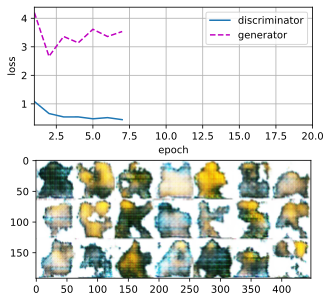

In [ ]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(discriminator, generator, data_iter, num_epochs, lr, latent_dim)

## Conclusion
Wow! This Pockermon looks so great!